In [1]:
import hydra
from glob import  glob
from proteoscope.datamodule import ProteoscopeDataModule
from proteoscope.cytoselfmodule import CytoselfLightningModule
import numpy as np
from omegaconf import OmegaConf


# BASE_DIR = "/home/ec2-user/outputs-proteoscope/2023-05-26/20-52-13"
BASE_DIR = "/home/ec2-user/outputs-proteoscope/2023-05-28/05-51-25"
config_dir = BASE_DIR + "/.hydra"

with hydra.initialize_config_dir(config_dir=config_dir):
    config = hydra.compose(config_name="config", overrides=OmegaConf.load(config_dir + "/overrides.yaml"))

    chkpts = glob(BASE_DIR + "/checkpoints/*.ckpt")
    chkpts.sort()
    chkpt = chkpts[-1]
    print('   Using ', chkpt)


    pdm = ProteoscopeDataModule(
        images_path=config.data.images_path,
        labels_path=config.data.labels_path,
        batch_size=config.trainer.batch_size,
        num_workers=config.trainer.num_workers,
    )
    pdm.setup()

    clm = CytoselfLightningModule.load_from_checkpoint(
        chkpt,
        module_config=config.module,
        num_class=pdm.num_class,
    )

/tmp/ipykernel_21950/770420382.py:13: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with hydra.initialize_config_dir(config_dir=config_dir):


   Using  /home/ec2-user/outputs-proteoscope/2023-05-28/05-51-25/checkpoints/last.ckpt


/opt/conda/envs/pytorch/lib/python3.9/site-packages/torchvision/ops/misc.py:120: UserWarning: Don't use ConvNormActivation directly, please use Conv2dNormActivation and Conv3dNormActivation instead.
  warnings.warn(


In [6]:
dl = pdm.val_dataloader(novel_proteins=False, shuffle=True)
batch = next(iter(dl))

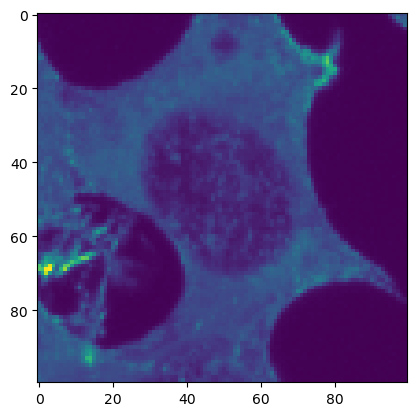

In [7]:
import matplotlib.pyplot as plt
plt.imshow(batch['image'][2, 0])

In [8]:
input_images = batch['image']
output_images, output_logits = clm.model(input_images)
output_images = output_images.detach().numpy()

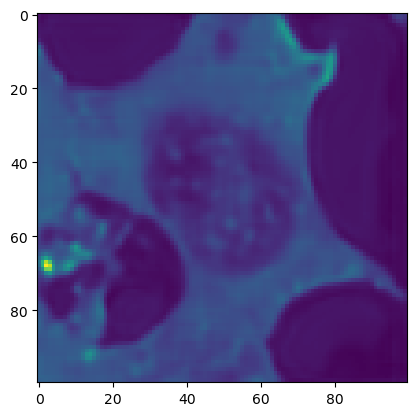

In [9]:
plt.imshow(output_images[2, 0])

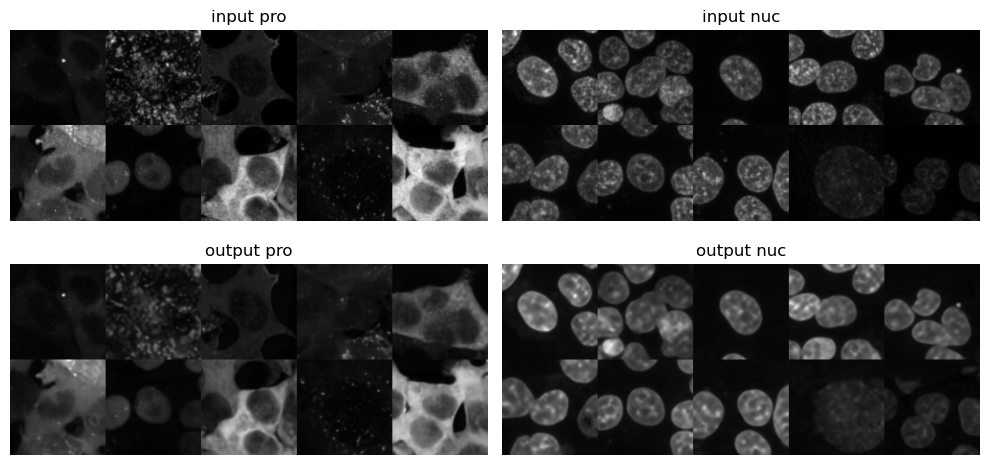

In [10]:
data_ch = ['pro', 'nuc']
fig, ax = plt.subplots(2, len(data_ch), figsize=(5 * len(data_ch), 5), squeeze=False)
for ii, ch in enumerate(data_ch):
    t0 = np.zeros((2 * 100, 5 * 100))
    for i, im in enumerate(input_images[:10, ii, ...]):
        i0, i1 = np.unravel_index(i, (2, 5))
        t0[i0 * 100 : (i0 + 1) * 100, i1 * 100 : (i1 + 1) * 100] = im
    t1 = np.zeros((2 * 100, 5 * 100))
    for i, im in enumerate(output_images[:10, ii, ...]):
        i0, i1 = np.unravel_index(i, (2, 5))
        t1[i0 * 100 : (i0 + 1) * 100, i1 * 100 : (i1 + 1) * 100] = im
    ax[0, ii].imshow(t0, cmap='gray')
    ax[0, ii].axis('off')
    ax[0, ii].set_title('input ' + ch)
    ax[1, ii].imshow(t1, cmap='gray')
    ax[1, ii].axis('off')
    ax[1, ii].set_title('output ' + ch)
fig.tight_layout()
fig.show()
# fig.savefig(join(trainer.savepath_dict['visualization'], 'reconstructed_images.png'), dpi=300)

In [11]:
embedding = clm.model(batch['image'], 'vqvec2')

In [12]:
import torch
from tqdm import tqdm


clm.model.to('cuda')
embeddings = []
for batch in tqdm(pdm.val_dataloader()):
    emb = clm.model(batch['image'].to('cuda'), 'vqvec2')
    embeddings.append(emb.detach().cpu().numpy())
embeddings = np.concatenate(embeddings, axis=0)

100%|██████████| 1424/1424 [00:57<00:00, 24.55it/s]


In [13]:
import zarr
from os.path import join

datapath = "/home/ec2-user/cytoself-data/"
zarr_path = join(datapath, "embeddings_2.zarr")

shape = embeddings.shape
chunks = (100, None, None, None)
z = zarr.open(zarr_path, mode="a", shape=shape, chunks=chunks)
z[:] = embeddings

# embeddings = np.asarray(zarr.open(zarr_path, mode='r'))

In [14]:
embeddings.shape

(91108, 64, 4, 4)

In [15]:
import umap


n_neighbors = 15
min_dist = 0.1
metric = 'euclidean'
reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, metric=metric)
reducer.fit(embeddings.reshape(embeddings.shape[0], -1))

UMAP(tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

In [16]:
reduced_embedding = reducer.transform(embeddings.reshape(embeddings.shape[0], -1))

In [17]:
reduced_embedding.shape

(91108, 2)

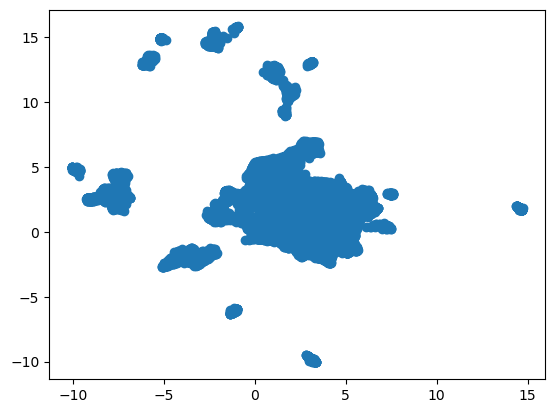

In [18]:
plt.scatter(reduced_embedding[:, 0], reduced_embedding[:, 1]);

In [19]:
labels = pdm.val_dataloader().dataset.labels['loc_grade1']

In [20]:
labels_full = labels.str.split(';', expand=True).stack()

In [21]:
labels_full.unique()

array(['cytoplasmic', 'nucleoplasm', 'nuclear_punctae', 'mitochondria',
       'vesicles', 'er', 'membrane', '', 'centrosome', 'golgi',
       'nuclear_membrane', 'big_aggregates', 'cell_contact',
       'cytoskeleton', 'nucleolus_gc', 'focal_adhesions', 'chromatin',
       'nucleolus_fc_dfc'], dtype=object)

In [22]:
(labels == '').sum()

420

In [23]:
labels_full

4980     0    cytoplasmic
5018     0    cytoplasmic
5023     0    cytoplasmic
5028     0    cytoplasmic
5060     0    cytoplasmic
                 ...     
1134570  0             er
1134574  0             er
1134576  0             er
1134579  0             er
1134591  0             er
Length: 125780, dtype: object

In [24]:
labels_full.unique()

array(['cytoplasmic', 'nucleoplasm', 'nuclear_punctae', 'mitochondria',
       'vesicles', 'er', 'membrane', '', 'centrosome', 'golgi',
       'nuclear_membrane', 'big_aggregates', 'cell_contact',
       'cytoskeleton', 'nucleolus_gc', 'focal_adhesions', 'chromatin',
       'nucleolus_fc_dfc'], dtype=object)

In [25]:
pdm.val_dataloader().dataset.labels.head()

,ensg,name,loc_grade1,loc_grade2,loc_grade3,protein_id,FOV_id,split_protein,split_images,label,Peptide,Protein stable ID,seq_embedding_index,truncation
4980,ENSG00000105401,CDC37,cytoplasmic,nucleoplasm,,10,6206,train,val,0,MVDYSVWDHIEVSDDEDETHPNIDTASLFRWRHQARVERMEQFQKE...,ENSP00000222005,4,378
5018,ENSG00000105401,CDC37,cytoplasmic,nucleoplasm,,10,6206,train,val,0,MVDYSVWDHIEVSDDEDETHPNIDTASLFRWRHQARVERMEQFQKE...,ENSP00000222005,4,378
5023,ENSG00000105401,CDC37,cytoplasmic,nucleoplasm,,10,6206,train,val,0,MVDYSVWDHIEVSDDEDETHPNIDTASLFRWRHQARVERMEQFQKE...,ENSP00000222005,4,378
5028,ENSG00000105401,CDC37,cytoplasmic,nucleoplasm,,10,6206,train,val,0,MVDYSVWDHIEVSDDEDETHPNIDTASLFRWRHQARVERMEQFQKE...,ENSP00000222005,4,378
5060,ENSG00000105401,CDC37,cytoplasmic,nucleoplasm,,10,6202,train,val,0,MVDYSVWDHIEVSDDEDETHPNIDTASLFRWRHQARVERMEQFQKE...,ENSP00000222005,4,378


In [26]:
pdm.val_dataloader().dataset.labels

,ensg,name,loc_grade1,loc_grade2,loc_grade3,protein_id,FOV_id,split_protein,split_images,label,Peptide,Protein stable ID,seq_embedding_index,truncation
4980,ENSG00000105401,CDC37,cytoplasmic,nucleoplasm,,10,6206,train,val,0,MVDYSVWDHIEVSDDEDETHPNIDTASLFRWRHQARVERMEQFQKE...,ENSP00000222005,4,378
5018,ENSG00000105401,CDC37,cytoplasmic,nucleoplasm,,10,6206,train,val,0,MVDYSVWDHIEVSDDEDETHPNIDTASLFRWRHQARVERMEQFQKE...,ENSP00000222005,4,378
5023,ENSG00000105401,CDC37,cytoplasmic,nucleoplasm,,10,6206,train,val,0,MVDYSVWDHIEVSDDEDETHPNIDTASLFRWRHQARVERMEQFQKE...,ENSP00000222005,4,378
5028,ENSG00000105401,CDC37,cytoplasmic,nucleoplasm,,10,6206,train,val,0,MVDYSVWDHIEVSDDEDETHPNIDTASLFRWRHQARVERMEQFQKE...,ENSP00000222005,4,378
5060,ENSG00000105401,CDC37,cytoplasmic,nucleoplasm,,10,6202,train,val,0,MVDYSVWDHIEVSDDEDETHPNIDTASLFRWRHQARVERMEQFQKE...,ENSP00000222005,4,378
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1134570,ENSG00000125912,NCLN,er,,vesicles,2039,38864,train,val,1048,MLEEAGEVLENMLKASCLPLGFIVFLPAVLLLVAPPLPAADAAHEF...,ENSP00000246117,1310,563
1134574,ENSG00000125912,NCLN,er,,vesicles,2039,38864,train,val,1048,MLEEAGEVLENMLKASCLPLGFIVFLPAVLLLVAPPLPAADAAHEF...,ENSP00000246117,1310,563
1134576,ENSG00000125912,NCLN,er,,vesicles,2039,38864,train,val,1048,MLEEAGEVLENMLKASCLPLGFIVFLPAVLLLVAPPLPAADAAHEF...,ENSP00000246117,1310,563
1134579,ENSG00000125912,NCLN,er,,vesicles,2039,38864,train,val,1048,MLEEAGEVLENMLKASCLPLGFIVFLPAVLLLVAPPLPAADAAHEF...,ENSP00000246117,1310,563


In [27]:
label_groups = ['cytoplasmic',
          'er',
          'golgi',
          'mitochondia',
        #   'nuclear domains',
          'nuclear_membrane',
        #   'nucleus',
        #   'nucleoplasm',
          'vesicles',
        #   'others',
          ]

In [28]:
labels.loc[labels.str.contains(';', na=False)] = 'others'

/tmp/ipykernel_21950/1550532015.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels.loc[labels.str.contains(';', na=False)] = 'others'


In [29]:
labels.unique()

array(['cytoplasmic', 'others', 'nucleoplasm', 'mitochondria', 'vesicles',
       'er', 'membrane', '', 'centrosome', 'nuclear_membrane',
       'big_aggregates', 'golgi', 'cytoskeleton', 'nucleolus_gc',
       'nuclear_punctae', 'focal_adhesions', 'chromatin',
       'nucleolus_fc_dfc', 'cell_contact'], dtype=object)

In [30]:
import seaborn as sns

In [31]:
keep = labels.isin(label_groups)

<AxesSubplot:>

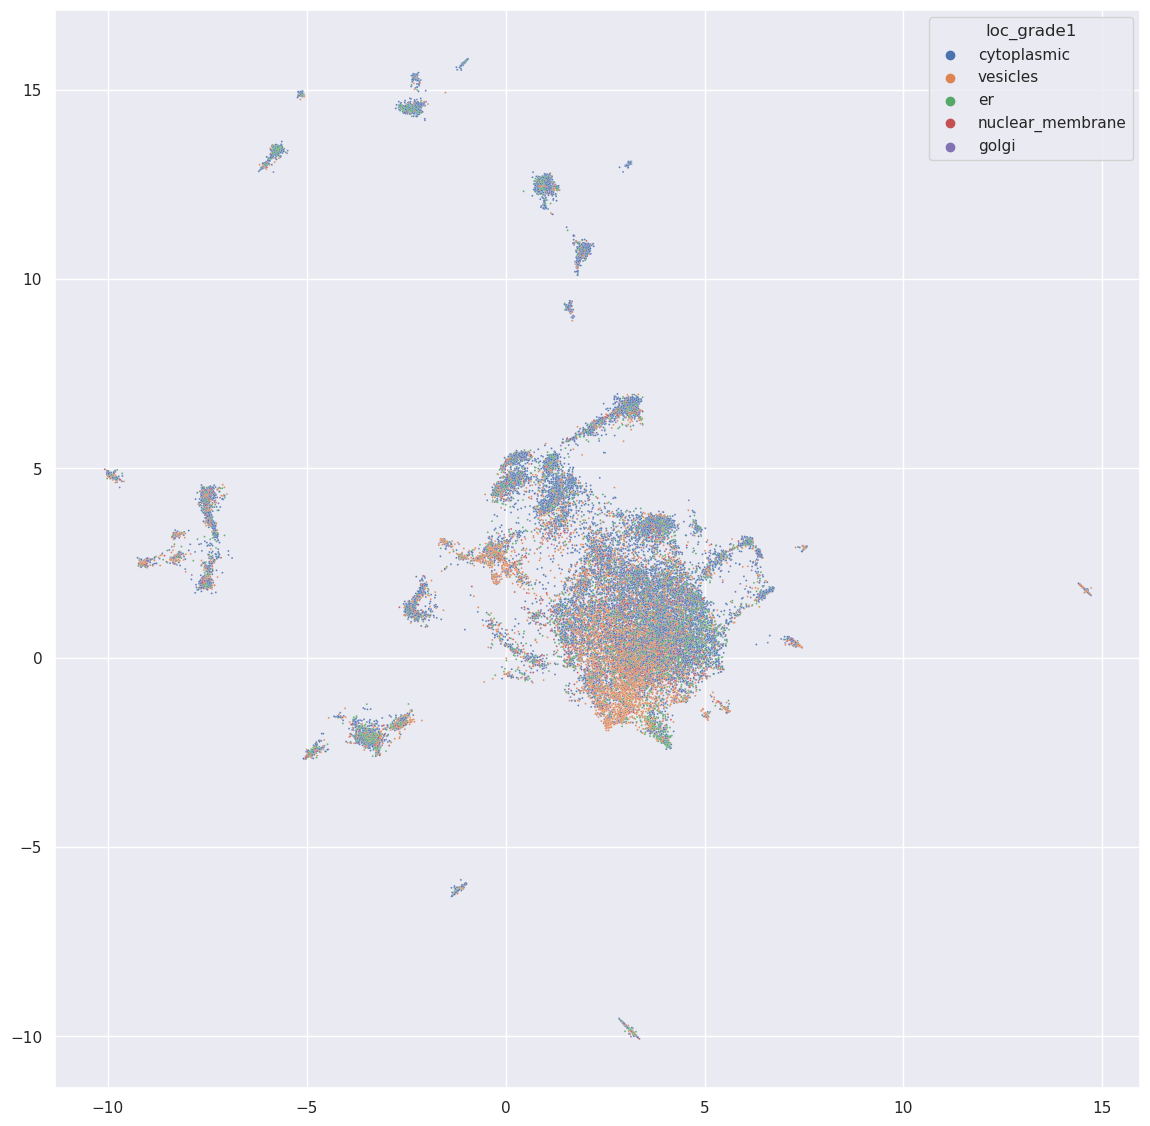

In [32]:
sns.set(rc={"figure.figsize":(14, 14)})
sns.scatterplot(x=reduced_embedding[keep, 0], y=reduced_embedding[keep, 1], hue=labels[keep], s=2, alpha=0.9)

In [33]:
embeddings[:, 1].shape

(91108, 4, 4)

In [ ]:
from cytoself.analysis.analysis_opencell import AnalysisOpenCell

analysis = AnalysisOpenCell(datamanager, trainer)
umap_data = analysis.plot_umap_of_embedding_vector(
    data_loader=datamanager.test_loader,
    group_col=2,
    output_layer=f'{model_args["fc_input_type"]}2',
    title=f'UMAP {model_args["fc_input_type"]}2',
    xlabel='UMAP1',
    ylabel='UMAP2',
    s=0.3,
    alpha=0.5,
    show_legend=True,
)

In [1]:
from proteoscope.datamodule import ProteoscopeDataModule

In [2]:
import os

datapath = '/home/ec2-user/cytoself-data'
images_path = os.path.join(datapath, 'images.zarr')
labels_path = os.path.join(datapath, 'labels.csv')

pdm = ProteoscopeDataModule(images_path, labels_path)
pdm.setup()

In [3]:
# import pandas as pd

# df = pd.read_csv(labels_path, index_col=0)
# df.to_csv(labels_path)

In [4]:
dl = pdm.train_dataloader()
batch = next(iter(dl))

In [5]:
pdm.train_loader = pdm.train_dataloader()
pdm.train_variance = 0.0161394402384758

In [6]:
pdm.train_labels = len(pdm.train_dataset.labels['label'].unique())

In [7]:
import matplotlib.pyplot as plt

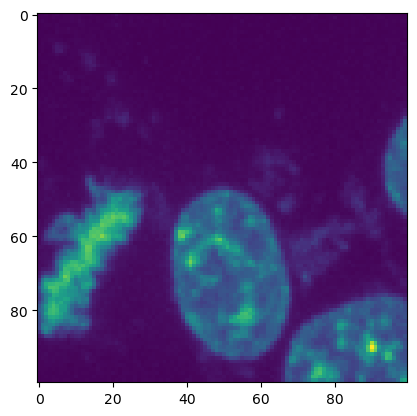

In [8]:
plt.imshow(batch['image'][0, 1])

## Train

In [9]:
from os.path import join
import numpy as np
import torch
import matplotlib.pyplot as plt

from cytoself.datamanager.opencell import DataManagerOpenCell
from cytoself.trainer.cytoselflite_trainer import CytoselfFullTrainer
from cytoself.analysis.analysis_opencell import AnalysisOpenCell
from cytoself.trainer.utils.plot_history import plot_history_cytoself

# data_ch = ['pro', 'nuc'] # , 'nucdist', 'label']
# # datapath = '/home/ec2-user/cytoself'
# datapath = 'sample_data'
# datamanager = DataManagerOpenCell(datapath, data_ch, fov_col=None)
# datamanager.const_dataloader(batch_size=32, label_name_position=1)

In [10]:
# datamanager.train_variance
# datamanager.train_loader.dataset[2]['image'].shape
# plt.imshow(datamanager.train_loader.dataset[2]['image'][0])

In [11]:
# num_classes = len(datamanager.unique_labels)
num_classes = pdm.train_labels
model_args = {
    'input_shape': (2, 100, 100),
    'emb_shapes': ((25, 25), (4, 4)),
    'output_shape': (2, 100, 100),
    'fc_output_idx': [2],
    'vq_args': {'num_embeddings': 512, 'embedding_dim': 64},
    'num_class': num_classes,
    'fc_input_type': 'vqvec',
}
train_args = {
    'lr': 1e-3,
    'max_epoch': 10,
    'reducelr_patience': 3,
    'reducelr_increment': 0.1,
    'earlystop_patience': 6,
}
trainer = CytoselfFullTrainer(train_args, homepath='demo_output', model_args=model_args)
# trainer.fit(pdm, tensorboard_path='tb_logs')

/opt/conda/envs/pytorch/lib/python3.9/site-packages/torchvision/ops/misc.py:120: UserWarning: Don't use ConvNormActivation directly, please use Conv2dNormActivation and Conv3dNormActivation instead.
  warnings.warn(


In [1]:
from cytoself.trainer.autoencoder.cytoselffull import CytoselfFull

In [2]:
model_args = {
    'input_shape': (2, 100, 100),
    'emb_shapes': ((25, 25), (4, 4)),
    'output_shape': (2, 100, 100),
    'fc_output_idx': [2],
    'vq_args': {'num_embeddings': 512, 'embedding_dim': 64},
    'num_class': 100,
    'fc_input_type': 'vqvec',
}

model = CytoselfFull(**model_args)

/opt/conda/envs/pytorch/lib/python3.9/site-packages/torchvision/ops/misc.py:120: UserWarning: Don't use ConvNormActivation directly, please use Conv2dNormActivation and Conv3dNormActivation instead.
  warnings.warn(


In [3]:
from cytoself.trainer.autoencoder.cytoselffull import duplicate_kwargs

In [5]:
duplicate_kwargs(model_args['vq_args'], model_args['emb_shapes'])

[{'num_embeddings': 512, 'embedding_dim': 64, 'channel_split': 1},
 {'num_embeddings': 512, 'embedding_dim': 64, 'channel_split': 1}]

In [6]:
type(model_args['vq_args'])

dict

In [14]:
import torch.nn as nn

image_criterion = nn.MSELoss()
labels_criterion = nn.CrossEntropyLoss()

In [15]:
images = batch['image']
labels = batch['label']
output_images, output_logits = model(images)

In [16]:
image_variance = 1
model.mse_loss['reconstruction1_loss'] = image_criterion(output_images, images) / image_variance
model.fc_loss = {f'fc{model.fc_output_idx[0]}_loss' :labels_criterion(output_logits, labels)}
vq_loss = torch.stack([d['loss'] for d in model.vq_loss.values()]).sum()
mse_loss = torch.stack([d for d in model.mse_loss.values()]).sum()
fc_loss = torch.stack([d for d in model.fc_loss.values()]).sum()

In [17]:
vq_coeff = 1
fc_coeff = 1

loss = mse_loss + fc_coeff * fc_loss + vq_coeff * vq_loss

In [18]:
loss

tensor(9.5200, grad_fn=<AddBackward0>)

In [19]:
vq_loss

tensor(1.1138, grad_fn=<SumBackward0>)

In [20]:
model.vq_loss

{'vq1': {'loss': tensor(0.4824, grad_fn=<AddBackward0>),
  'commitment_loss': tensor(0.3859),
  'quantization_loss': tensor(0.3859),
  'softmax_loss': tensor(5.4028)},
 'vq2': {'loss': tensor(0.6314, grad_fn=<AddBackward0>),
  'commitment_loss': tensor(0.5051),
  'quantization_loss': tensor(0.5051),
  'softmax_loss': tensor(5.6080)}}

In [21]:
model.perplexity

{'perplexity1': tensor(195.3579), 'perplexity2': tensor(142.3069)}

In [22]:
model.fc_output_idx

[2]

In [23]:
model.fc_loss

{'fc2_loss': tensor(6.9681, grad_fn=<NllLossBackward0>)}

In [24]:
output = {'loss': loss.item()}
output.update({k: v.item() for k, v in model.fc_loss.items()})
output.update({k: v.item() for k, v in model.perplexity.items()})
output.update({k: model.mse_loss[k].item() for k in sorted(model.mse_loss)})
vq_loss_dict = {}
for key0, val0 in model.vq_loss.items():
    for key1, val1 in val0.items():
        vq_loss_dict[key0 + '_' + key1] = val1.item()
output.update(vq_loss_dict)

In [25]:
output

{'loss': 9.520021438598633,
 'fc2_loss': 6.968080997467041,
 'perplexity1': 195.35789489746094,
 'perplexity2': 142.306884765625,
 'reconstruction1_loss': 1.05869722366333,
 'reconstruction2_loss': 0.37946274876594543,
 'vq1_loss': 0.48237425088882446,
 'vq1_commitment_loss': 0.3858993947505951,
 'vq1_quantization_loss': 0.3858993947505951,
 'vq1_softmax_loss': 5.402750492095947,
 'vq2_loss': 0.6314069032669067,
 'vq2_commitment_loss': 0.5051255226135254,
 'vq2_quantization_loss': 0.5051255226135254,
 'vq2_softmax_loss': 5.6080217361450195}

In [26]:
trainer = CytoselfFullTrainer(train_args, homepath='demo_output', model_args=model_args)
output = trainer.run_one_batch(batch, 0.5)

In [27]:
trainer = CytoselfFullTrainer(train_args, homepath='demo_output', model_args=model_args)
output2 = trainer.run_one_batch(batch, 0.5)

In [28]:
output

{'loss': 9.516685485839844,
 'fc2_loss': 6.9556732177734375,
 'perplexity1': 206.7346649169922,
 'perplexity2': 145.45870971679688,
 'reconstruction1_loss': 1.1264398097991943,
 'reconstruction2_loss': 0.41523441672325134,
 'vq1_loss': 0.47022849321365356,
 'vq1_commitment_loss': 0.37618279457092285,
 'vq1_quantization_loss': 0.37618279457092285,
 'vq1_softmax_loss': 5.267338752746582,
 'vq2_loss': 0.5491094589233398,
 'vq2_commitment_loss': 0.43928754329681396,
 'vq2_quantization_loss': 0.43928754329681396,
 'vq2_softmax_loss': 5.451366424560547}

In [29]:
output2


{'loss': 10.102949142456055,
 'fc2_loss': 6.947620868682861,
 'perplexity1': 235.05003356933594,
 'perplexity2': 149.5159912109375,
 'reconstruction1_loss': 1.7394992113113403,
 'reconstruction2_loss': 0.40023669600486755,
 'vq1_loss': 0.51456218957901,
 'vq1_commitment_loss': 0.4116497337818146,
 'vq1_quantization_loss': 0.4116497337818146,
 'vq1_softmax_loss': 5.315371513366699,
 'vq2_loss': 0.5010303258895874,
 'vq2_commitment_loss': 0.40082424879074097,
 'vq2_quantization_loss': 0.40082424879074097,
 'vq2_softmax_loss': 5.46080207824707}

In [ ]:
plot_history_cytoself(trainer.history, savepath=trainer.savepath_dict['visualization'])

In [ ]:
img = next(iter(datamanager.test_loader))['image'].detach().cpu().numpy()
torch.cuda.empty_cache()
reconstructed = trainer.infer_reconstruction(img)
fig, ax = plt.subplots(2, len(data_ch), figsize=(5 * len(data_ch), 5), squeeze=False)
for ii, ch in enumerate(data_ch):
    t0 = np.zeros((2 * 100, 5 * 100))
    for i, im in enumerate(img[:10, ii, ...]):
        i0, i1 = np.unravel_index(i, (2, 5))
        t0[i0 * 100 : (i0 + 1) * 100, i1 * 100 : (i1 + 1) * 100] = im
    t1 = np.zeros((2 * 100, 5 * 100))
    for i, im in enumerate(reconstructed[:10, ii, ...]):
        i0, i1 = np.unravel_index(i, (2, 5))
        t1[i0 * 100 : (i0 + 1) * 100, i1 * 100 : (i1 + 1) * 100] = im
    ax[0, ii].imshow(t0, cmap='gray')
    ax[0, ii].axis('off')
    ax[0, ii].set_title('input ' + ch)
    ax[1, ii].imshow(t1, cmap='gray')
    ax[1, ii].axis('off')
    ax[1, ii].set_title('output ' + ch)
fig.tight_layout()
fig.show()
fig.savefig(join(trainer.savepath_dict['visualization'], 'reconstructed_images.png'), dpi=300)

In [ ]:
analysis = AnalysisOpenCell(datamanager, trainer)

In [ ]:
analysis.plot_clustermap(num_workers=4)

## Custom trainer

In [30]:
from proteoscope.cytoselfmodule import CytoselfLightningModule

In [31]:
clm = CytoselfLightningModule(model_args)

In [34]:
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger

In [35]:
trainer = Trainer()

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/conda/envs/pytorch/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(


In [36]:
trainer.fit(clm, pdm)

/opt/conda/envs/pytorch/lib/python3.9/site-packages/pytorch_lightning/loops/utilities.py:94: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
Missing logger folder: /home/ec2-user/proteoscope/notebooks/lightning_logs


In [ ]:
from cytoself.analysis.analysis_opencell import AnalysisOpenCell

analysis = AnalysisOpenCell(datamanager, trainer)
umap_data = analysis.plot_umap_of_embedding_vector(
    data_loader=datamanager.test_loader,
    group_col=2,
    output_layer=f'{model_args["fc_input_type"]}2',
    title=f'UMAP {model_args["fc_input_type"]}2',
    xlabel='UMAP1',
    ylabel='UMAP2',
    s=0.3,
    alpha=0.5,
    show_legend=True,
)

In [ ]:
# Compute bi-clustering heatmap
analysis.plot_clustermap(num_workers=4)

# Prepare image data
img = next(iter(datamanager.test_loader))['image'].detach().cpu().numpy()[:1]

# Compute index histogram
vqindhist1 = trainer.infer_embeddings(img, 'vqindhist1')

# Reorder the index histogram according to the bi-clustering heatmap
ft_spectrum = analysis.compute_feature_spectrum(vqindhist1)

# Generate a plot
import numpy as np
import matplotlib.pyplot as plt

x_max = ft_spectrum.shape[1] + 1
x_ticks = np.arange(0, x_max, 50)
fig, ax = plt.subplots(figsize=(10, 3))
ax.stairs(ft_spectrum[0], np.arange(x_max), fill=True)
ax.spines[['right', 'top']].set_visible(False)
ax.set_xlabel('Feature index')
ax.set_ylabel('Counts')
ax.set_xlim([0, x_max])
ax.set_xticks(x_ticks, analysis.feature_spectrum_indices[x_ticks])
fig.tight_layout()
fig.show()